In [1]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from PyALE import ale
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
import geopandas as gpd
import numpy as np

In [2]:
file_path = r"ModellingData_V3_PBE_ABE_NE.xlsx"
data = pd.read_excel(file_path)
data.head()

,GEOID,CT_5digit,bphigh,chd,diabetes,highchol,obesity,ABE1,ABE2,ABE3,ABE4,ABE5,ABE6,PBE1,PBE2,NE1,NE2,NE3
0,6037265301,265301,5.761042,0.500960,1.085414,6.762963,11.188110,-0.660764,0.692240,-0.394954,0.925184,-0.829787,0.235442,2.640152,-1.443477,0.059821,-0.053236,15.788235
1,6037401901,401901,16.223067,1.520913,2.788340,21.292775,35.741446,-0.316248,0.295115,-0.205460,0.128051,-0.506879,0.074576,2.905541,-1.458956,1.456775,-0.064177,18.570540
2,6037206020,206020,25.371634,3.241310,7.935621,23.024478,33.083716,-0.378863,0.253378,1.532130,3.858522,-0.640391,-0.504878,-0.537406,0.695641,2.116515,0.113467,18.510373
3,6037265303,265303,24.049650,3.103181,6.206362,23.079906,37.044221,0.275943,4.444663,-0.139991,-0.862088,-0.172616,-0.250905,2.788220,-1.508503,-0.018885,-0.016381,15.746365
4,6037222700,222700,28.248588,3.193318,5.895358,23.581431,49.864896,-0.465064,0.872278,0.292469,1.244664,-0.498661,0.033562,0.603629,-0.112641,1.575785,0.445801,17.049678


In [3]:
# Convert relevant object columns to numeric
columns_to_convert = [
    'bphigh', 'chd', 'diabetes', 'highchol', 'obesity',
    'ABE1', 'ABE2', 'ABE3', 'ABE4', 'ABE5', 'ABE6',
    'PBE1', 'PBE2',
    'NE1', 'NE2', 'NE3'
]

data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

# Select only the columns with float64 data type
float_cols = data.select_dtypes(include=['float64'])

# Fill missing values in float64 columns with the mean of each column
float_cols.fillna(float_cols.mean(), inplace=True)

# Replace the original columns in the DataFrame with the imputed columns
data[float_cols.columns] = float_cols

# Verify that missing values have been filled
print(data.isnull().sum())

GEOID        0
CT_5digit    0
bphigh       0
chd          0
diabetes     0
highchol     0
obesity      0
ABE1         0
ABE2         0
ABE3         0
ABE4         0
ABE5         0
ABE6         0
PBE1         0
PBE2         0
NE1          0
NE2          0
NE3          0
dtype: int64


In [4]:
shapefile = gpd.read_file(r'C:\Users\24652\Desktop\Study area\CENSUS_Tracts.shp') 

In [5]:
# Ensure geoid column names match between the two datasets
data['GEOID'] = data['GEOID'].astype(str)
shapefile['GEOID'] = shapefile['GEOID'].astype(str).str[1:]

In [6]:
# Merge CSV and Shapefile on `geoid`
gdf = shapefile.merge(data, on='GEOID', how='right')

In [7]:
# Define independent variables
independent_vars = [
    'ABE1', 'ABE2', 'ABE3', 'ABE4', 'ABE5', 'ABE6',
    'PBE1', 'PBE2',
    'NE1', 'NE2', 'NE3'
]

# Define dependent variables
dependent_vars = ['bphigh', 'chd', 'diabetes', 'highchol', 'obesity']

# Step 2: Fit Global Random Forest Models and Save Results
importance_results = []


[ALE] bphigh


PyALE._ALE_generic:INFO: Continuous feature detected.


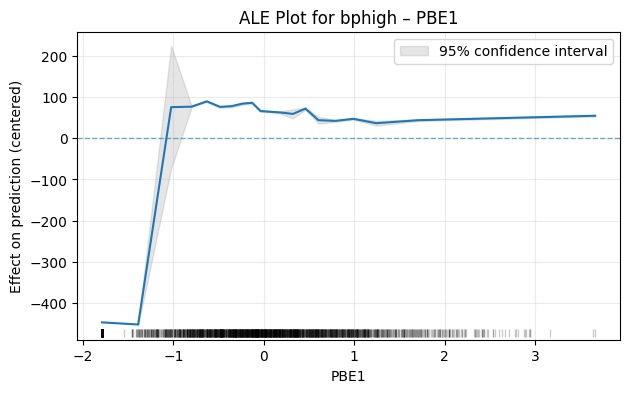

PyALE._ALE_generic:INFO: Continuous feature detected.


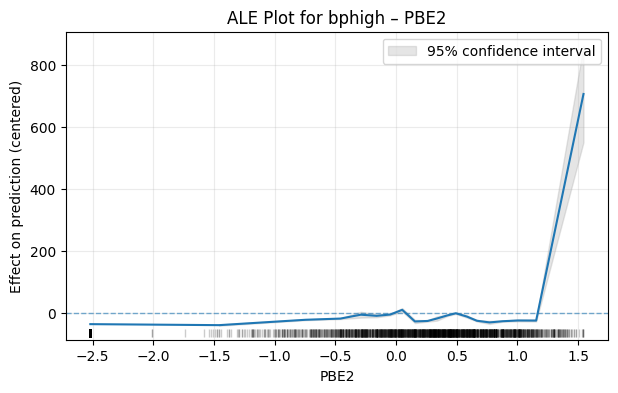

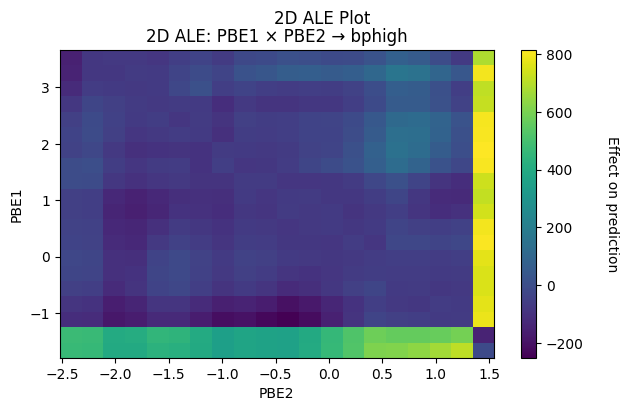


[ALE] chd


PyALE._ALE_generic:INFO: Continuous feature detected.


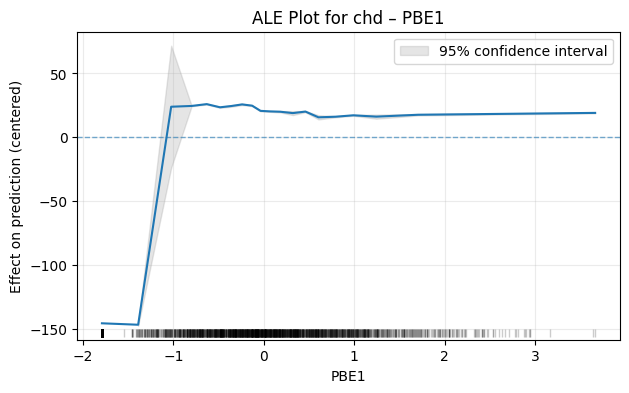

PyALE._ALE_generic:INFO: Continuous feature detected.


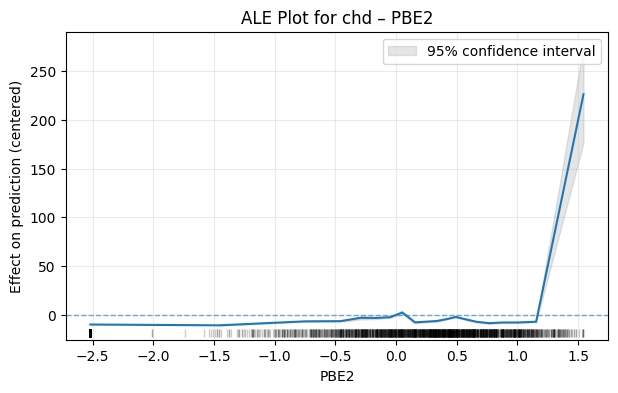

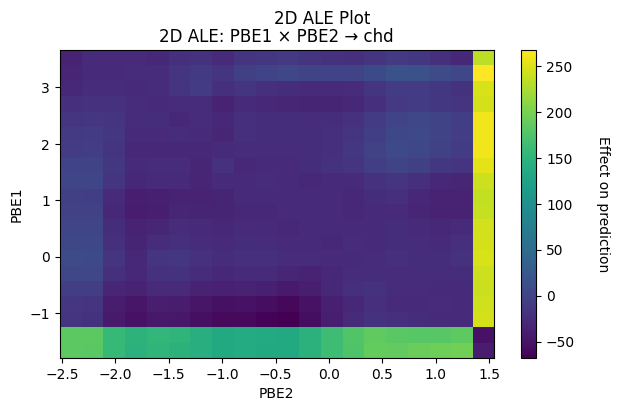


[ALE] diabetes


PyALE._ALE_generic:INFO: Continuous feature detected.


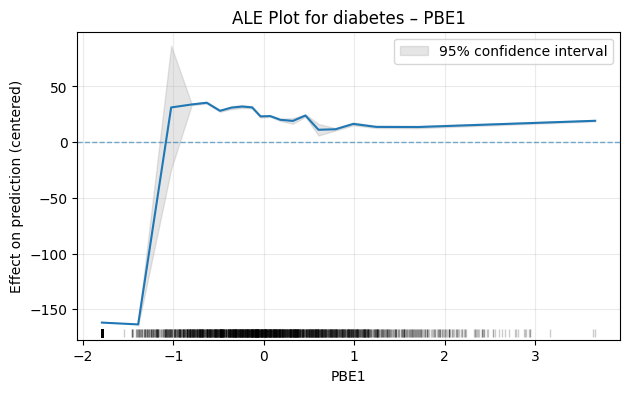

PyALE._ALE_generic:INFO: Continuous feature detected.


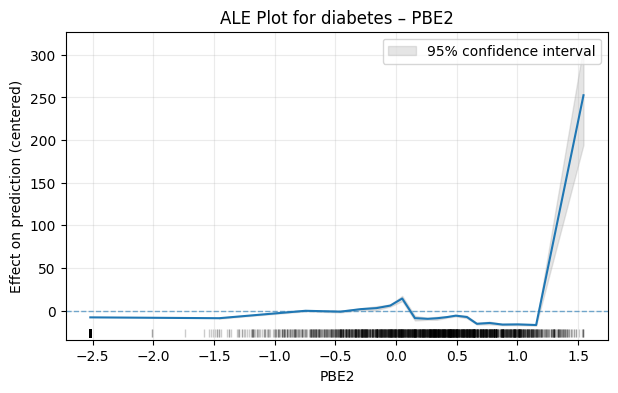

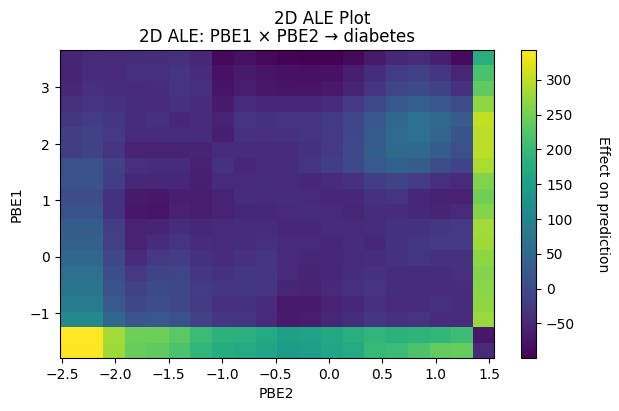


[ALE] highchol


PyALE._ALE_generic:INFO: Continuous feature detected.


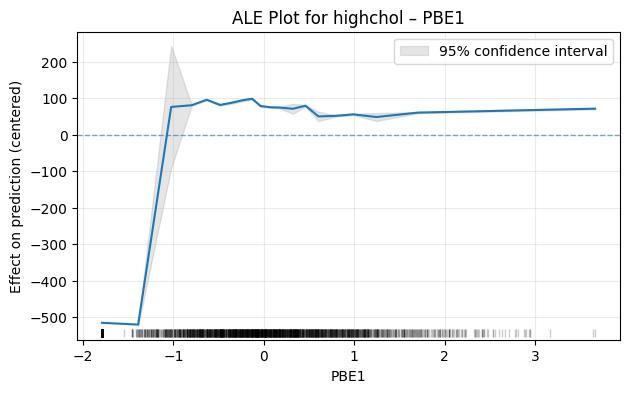

PyALE._ALE_generic:INFO: Continuous feature detected.


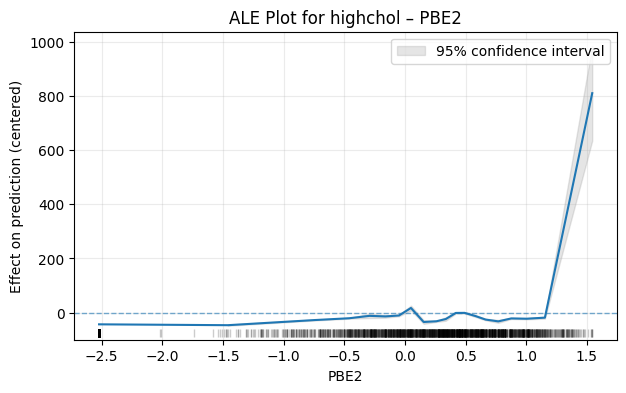

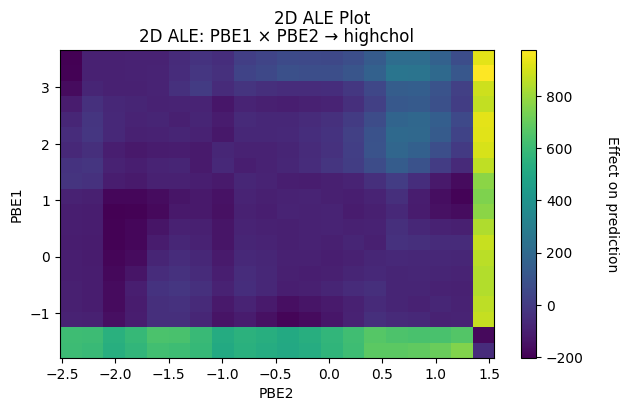


[ALE] obesity


PyALE._ALE_generic:INFO: Continuous feature detected.


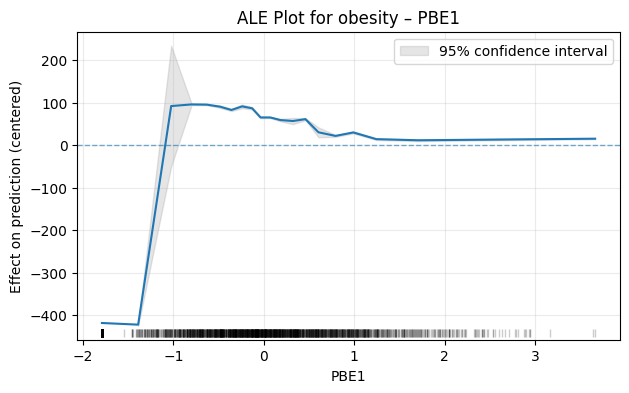

PyALE._ALE_generic:INFO: Continuous feature detected.


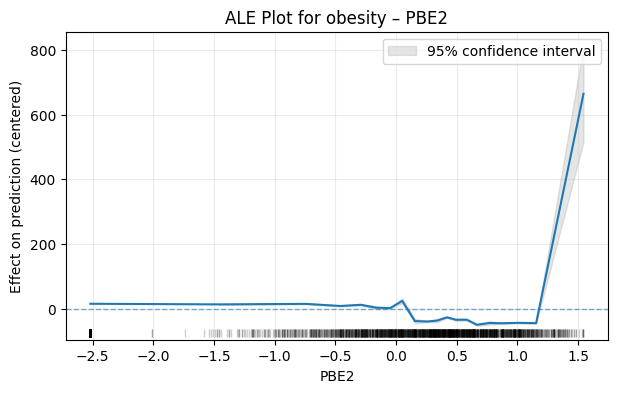

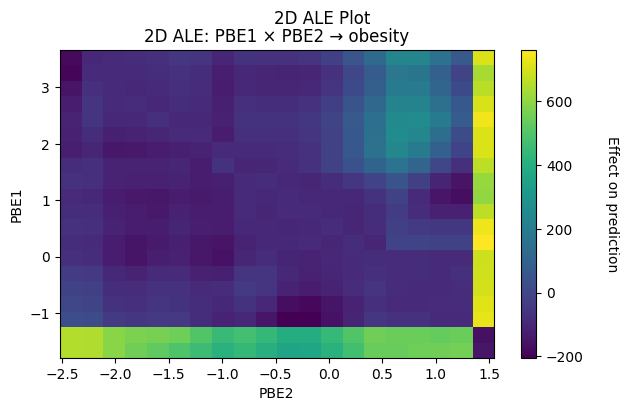

In [18]:
features_for_ale = ['PBE1', 'PBE2']
dependent_vars = ['bphigh', 'chd', 'diabetes', 'highchol', 'obesity']  # adjust if needed
grid = 20

for target in dependent_vars:
    print(f"\n[ALE] {target}")

    # Use only PBE1 & PBE2; drop rows with missing values
    df = gdf[features_for_ale + [target]].dropna(subset=features_for_ale + [target])
    X  = df[features_for_ale]
    y  = df[target]

    # Fit your specified RF (cap max_features to #cols to avoid errors)
    rf = RandomForestRegressor(
        n_estimators=500,
        max_features=min(6, X.shape[1]),
        random_state=42
    )
    rf.fit(X, y)

    # --- 1D ALE: analyze PBE1 (pass FULL X; specify feature=['PBE1']) ---
    fig, ax = plt.subplots(figsize=(7, 4))
    ale(
        X=X, model=rf,
        feature=['PBE1'], grid_size=grid,
        include_CI=True, fig=fig, ax=ax
    )
    ax.axhline(0, linestyle='--', linewidth=1, alpha=0.6)
    ax.set_xlabel('PBE1')
    ax.set_ylabel('Effect on prediction (centered)')
    ax.set_title(f"ALE Plot for {target} – PBE1")
    ax.grid(True, alpha=0.25)
    plt.show()

    # --- 1D ALE: analyze PBE2 (again pass FULL X) ---
    fig, ax = plt.subplots(figsize=(7, 4))
    ale(
        X=X, model=rf,
        feature=['PBE2'], grid_size=grid,
        include_CI=True, fig=fig, ax=ax
    )
    ax.axhline(0, linestyle='--', linewidth=1, alpha=0.6)
    ax.set_xlabel('PBE2')
    ax.set_ylabel('Effect on prediction (centered)')
    ax.set_title(f"ALE Plot for {target} – PBE2")
    ax.grid(True, alpha=0.25)
    plt.show()

    # --- 2D ALE: interaction PBE1 × PBE2 ---
    fig, ax = plt.subplots(figsize=(7, 4))
    ale(
        X=X, model=rf,
        feature=['PBE1', 'PBE2'], grid_size=grid,
        fig=fig, ax=ax
    )
    ax.set_title(f"2D ALE: PBE1 × PBE2 → {target}")
    plt.show()


[ALE] bphigh


PyALE._ALE_generic:INFO: Continuous feature detected.


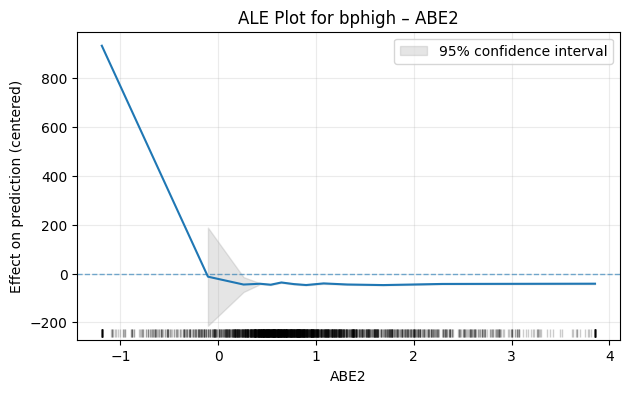

PyALE._ALE_generic:INFO: Continuous feature detected.


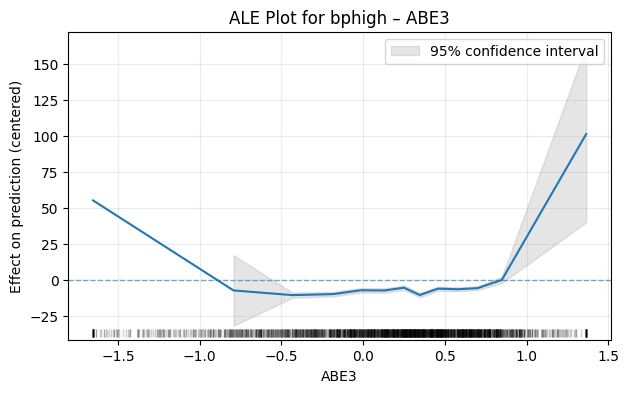

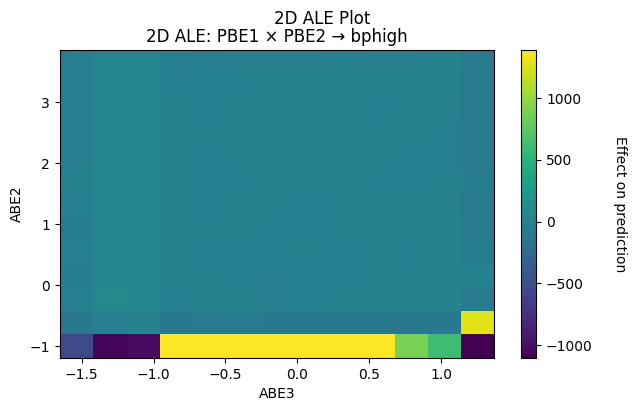


[ALE] chd


PyALE._ALE_generic:INFO: Continuous feature detected.


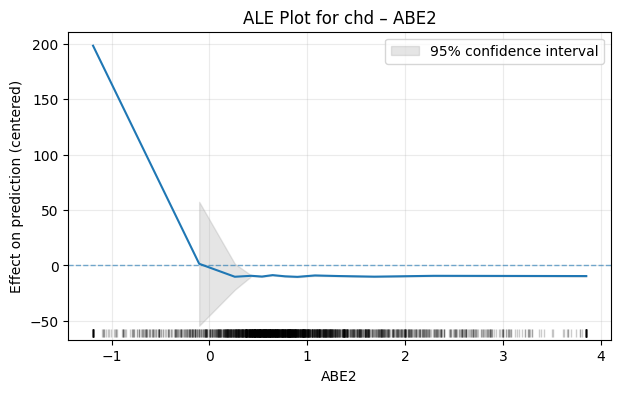

PyALE._ALE_generic:INFO: Continuous feature detected.


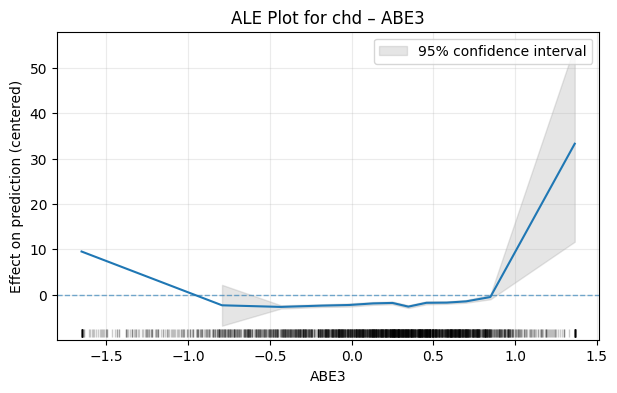

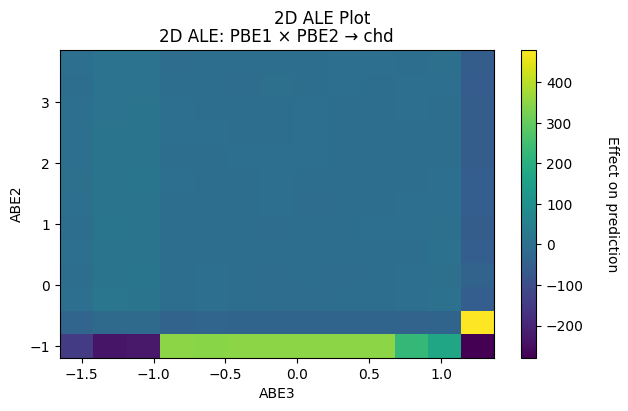


[ALE] diabetes


PyALE._ALE_generic:INFO: Continuous feature detected.


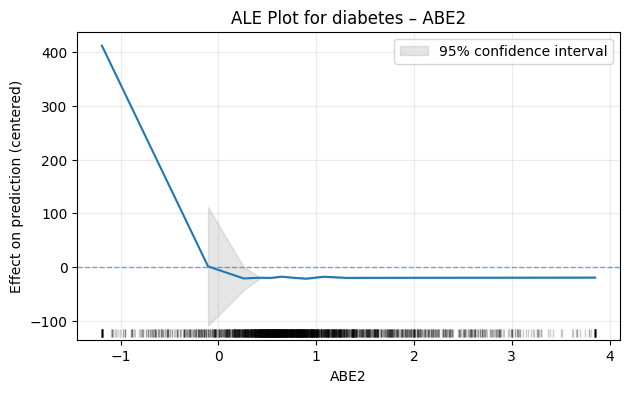

PyALE._ALE_generic:INFO: Continuous feature detected.


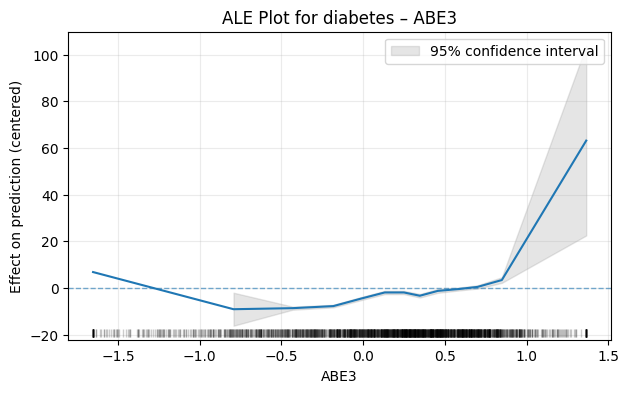

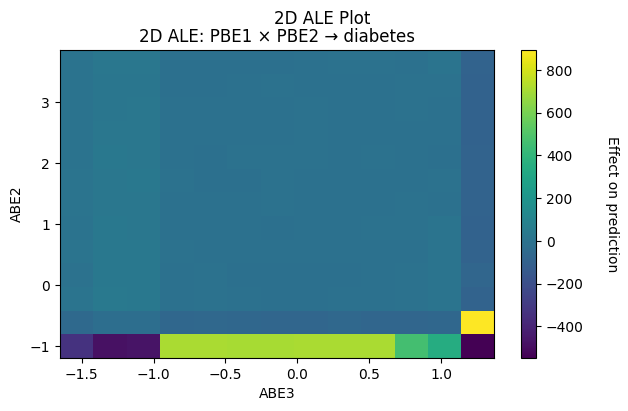


[ALE] highchol


PyALE._ALE_generic:INFO: Continuous feature detected.


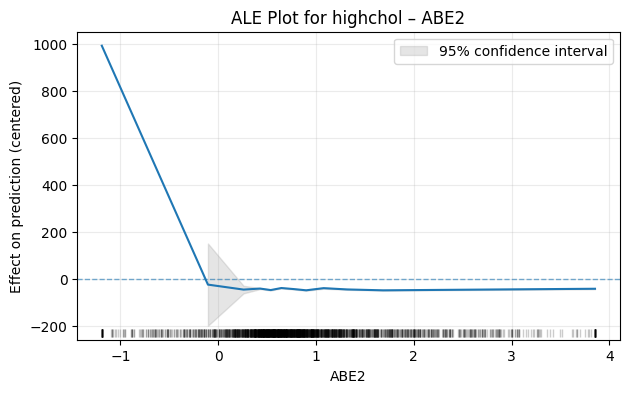

PyALE._ALE_generic:INFO: Continuous feature detected.


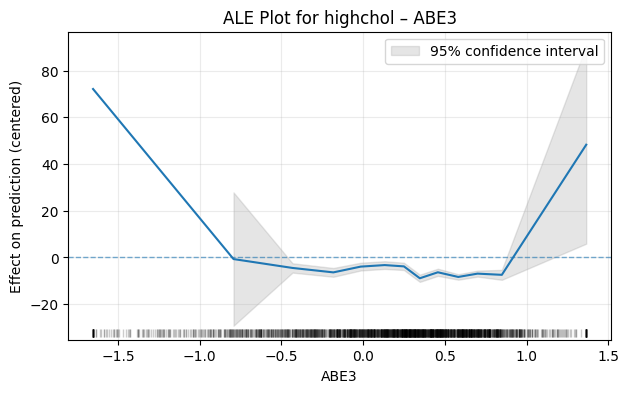

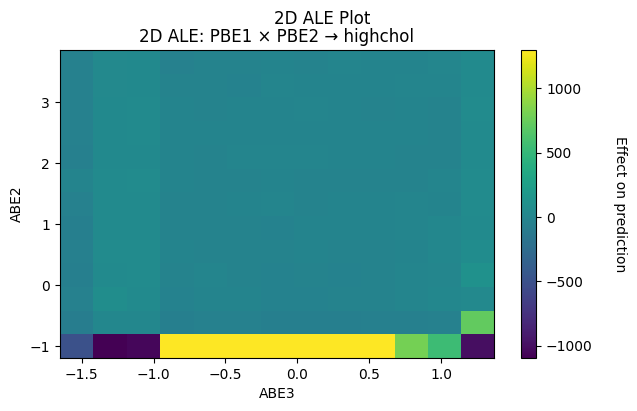


[ALE] obesity


PyALE._ALE_generic:INFO: Continuous feature detected.


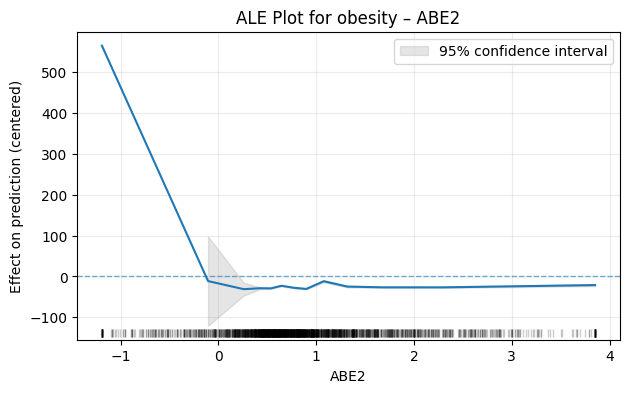

PyALE._ALE_generic:INFO: Continuous feature detected.


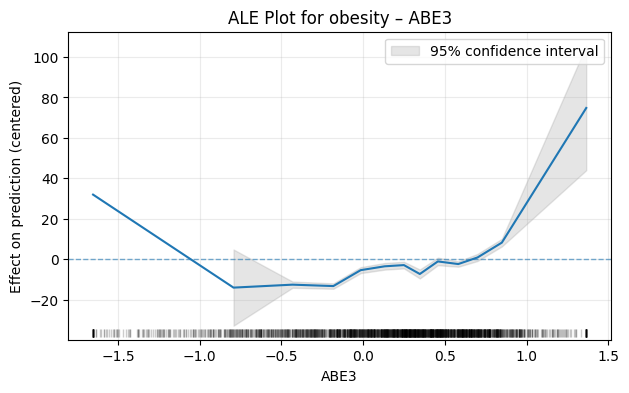

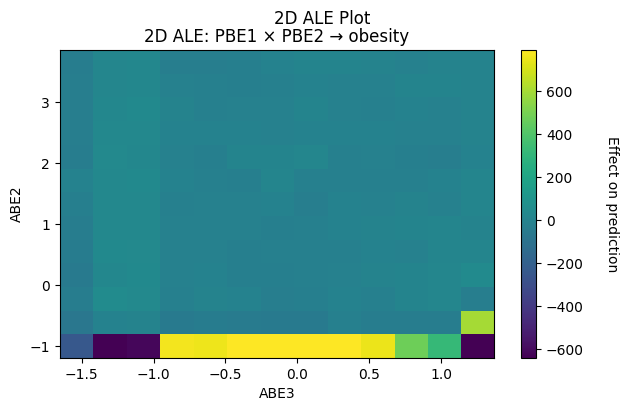

In [10]:
# --- settings you can tweak ---
features_for_ale = ['ABE2', 'ABE3']
dependent_vars   = ['bphigh', 'chd', 'diabetes', 'highchol', 'obesity']  # adjust to your list
winsor_lower_q   = 0.01   # clip bottom 1%
winsor_upper_q   = 0.99   # clip top 1%
grid_size_1d     = 12     # fewer bins = smoother tails
grid_size_2d     = 12

def winsorize(df: pd.DataFrame, cols, lower_q=0.01, upper_q=0.99):
    """Clip each column to [q(lower), q(upper)] to reduce outlier influence."""
    df = df.copy()
    for c in cols:
        low, high = df[c].quantile([lower_q, upper_q])
        df[c] = df[c].clip(lower=low, upper=high)
    return df

for target in dependent_vars:
    print(f"\n[ALE] {target}")

    # --- prepare data: keep only needed columns, drop rows w/ NaNs, winsorize PBE1/PBE2 ---
    df = gdf[features_for_ale + [target]].dropna(subset=features_for_ale + [target])
    df = winsorize(df, features_for_ale, winsor_lower_q, winsor_upper_q)
    X  = df[features_for_ale]
    y  = df[target]

    # --- fit your specified RF (cap max_features to number of columns) ---
    rf = RandomForestRegressor(
        n_estimators=500,
        max_features=min(6, X.shape[1]),
        random_state=42,
    )
    rf.fit(X, y)

    # ---- 1D ALE: PBE1 ----
    fig, ax = plt.subplots(figsize=(7, 4))
    ale(
        X=X, model=rf,
        feature=['ABE2'],
        grid_size=grid_size_1d,
        include_CI=True,
        fig=fig, ax=ax    # pass both to avoid CI error
    )
    ax.axhline(0, linestyle='--', linewidth=1, alpha=0.6)
    ax.set_xlabel('ABE2')
    ax.set_ylabel('Effect on prediction (centered)')
    ax.set_title(f"ALE Plot for {target} – ABE2")
    ax.grid(True, alpha=0.25)
    plt.show()

    # ---- 1D ALE: PBE2 ----
    fig, ax = plt.subplots(figsize=(7, 4))
    ale(
        X=X, model=rf,
        feature=['ABE3'],
        grid_size=grid_size_1d,
        include_CI=True,
        fig=fig, ax=ax
    )
    ax.axhline(0, linestyle='--', linewidth=1, alpha=0.6)
    ax.set_xlabel('ABE3')
    ax.set_ylabel('Effect on prediction (centered)')
    ax.set_title(f"ALE Plot for {target} – ABE3")
    ax.grid(True, alpha=0.25)
    plt.show()

    # ---- 2D ALE: interaction PBE1 × PBE2 ----
    fig, ax = plt.subplots(figsize=(7, 4))
    ale(
        X=X, model=rf,
        feature=['ABE2', 'ABE3'],
        grid_size=grid_size_2d,
        fig=fig, ax=ax
    )
    ax.set_title(f"2D ALE: PBE1 × PBE2 → {target}")
    plt.show()


[ALE] bphigh


PyALE._ALE_generic:INFO: Continuous feature detected.


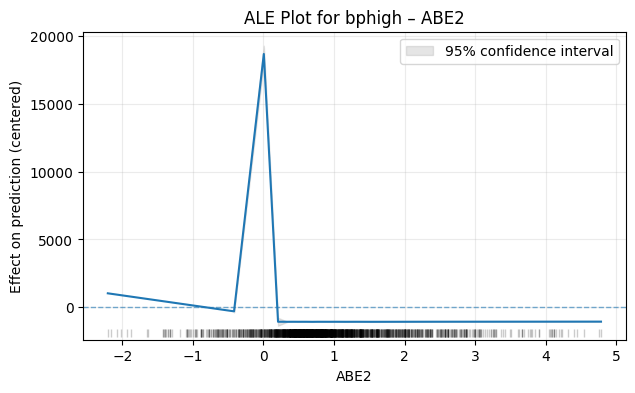

PyALE._ALE_generic:INFO: Continuous feature detected.


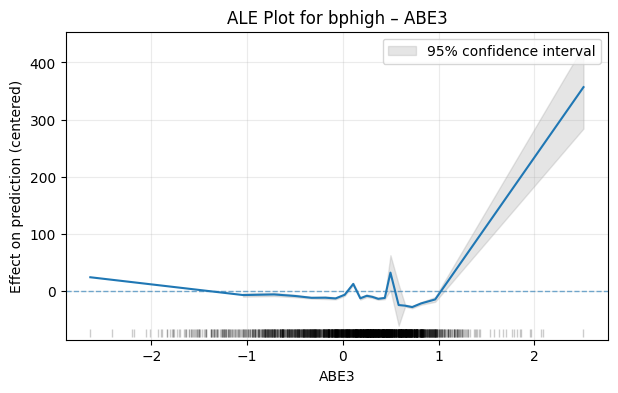

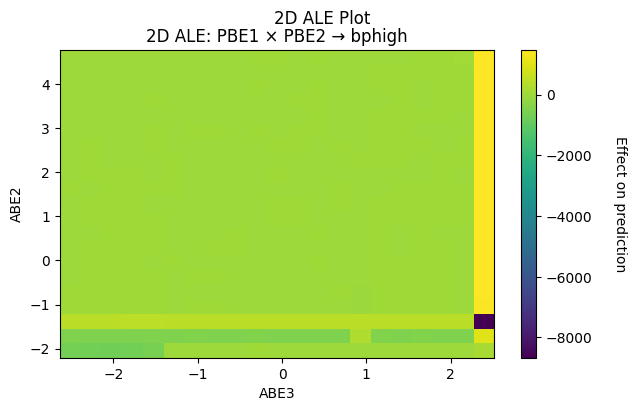


[ALE] chd


PyALE._ALE_generic:INFO: Continuous feature detected.


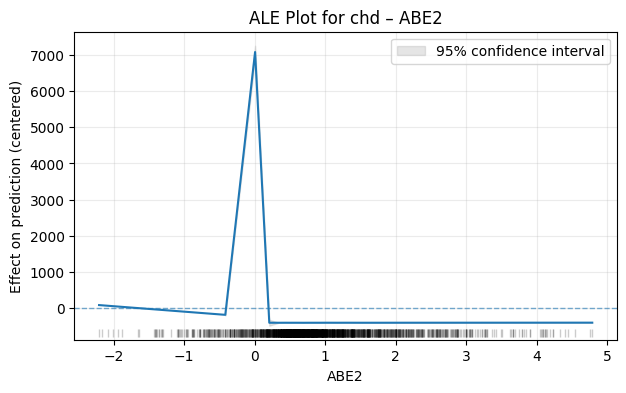

PyALE._ALE_generic:INFO: Continuous feature detected.


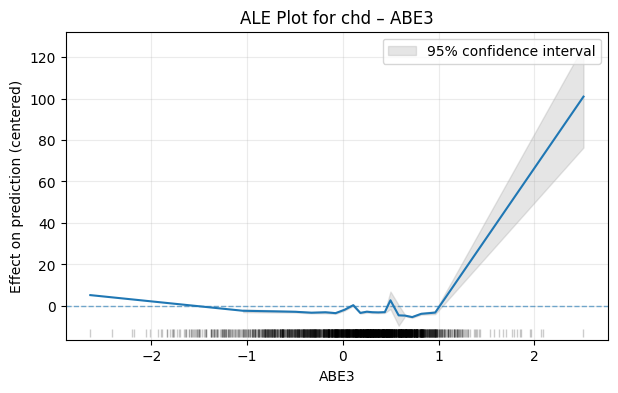

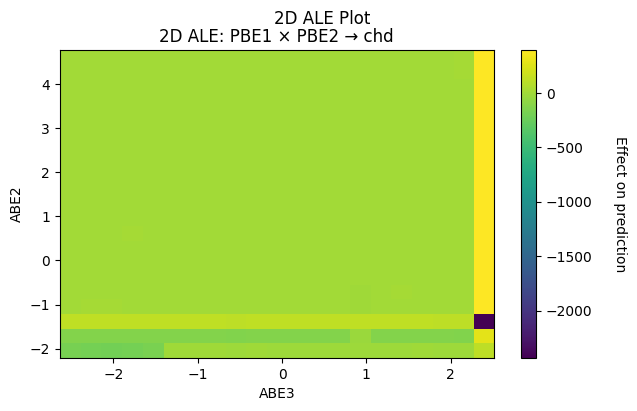


[ALE] diabetes


PyALE._ALE_generic:INFO: Continuous feature detected.


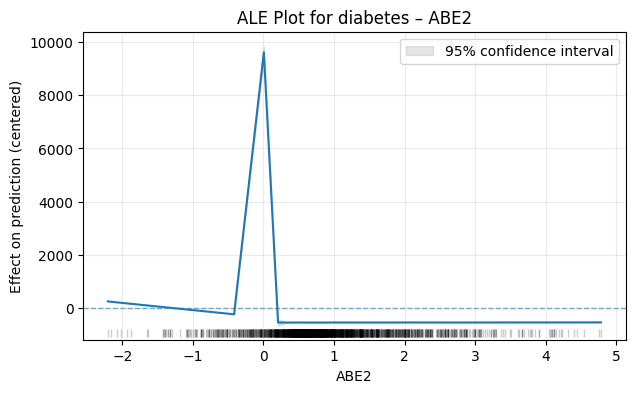

PyALE._ALE_generic:INFO: Continuous feature detected.


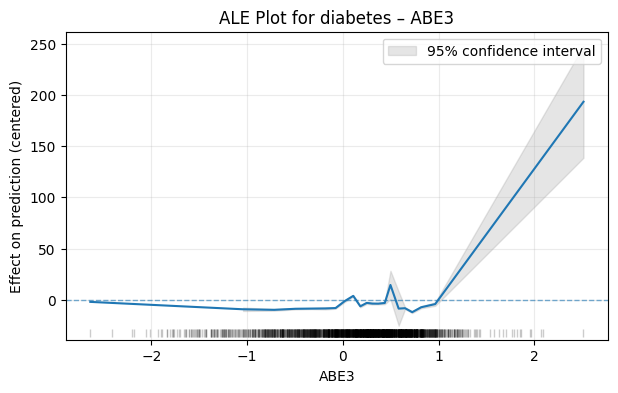

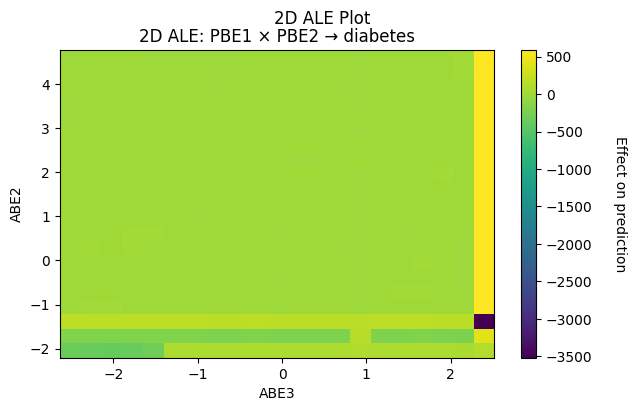


[ALE] highchol


PyALE._ALE_generic:INFO: Continuous feature detected.


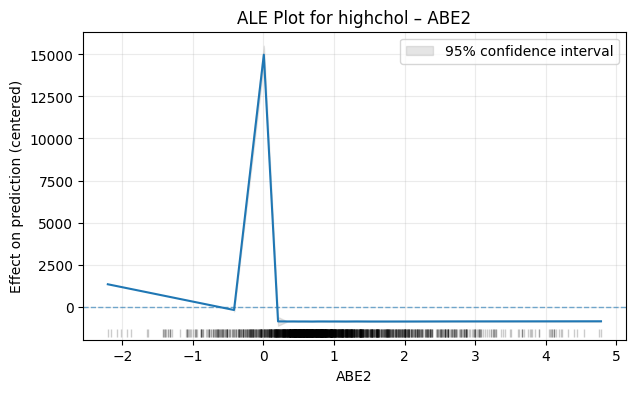

PyALE._ALE_generic:INFO: Continuous feature detected.


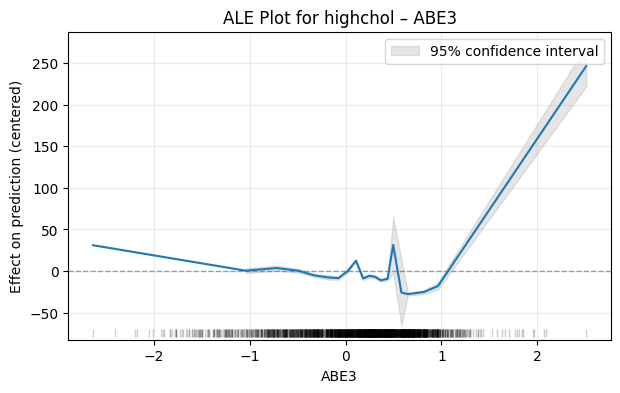

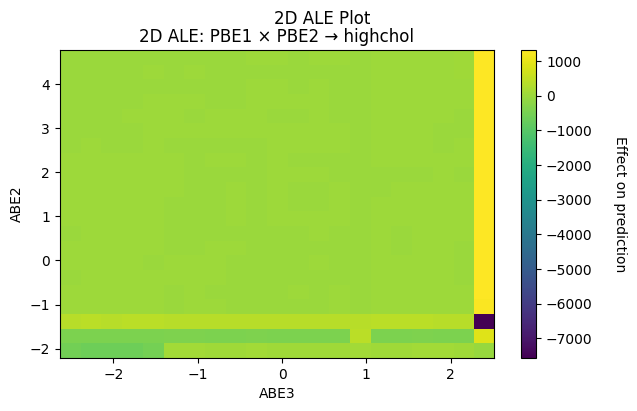


[ALE] obesity


PyALE._ALE_generic:INFO: Continuous feature detected.


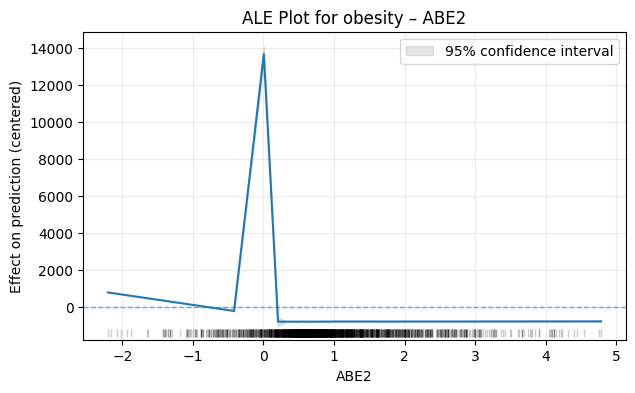

PyALE._ALE_generic:INFO: Continuous feature detected.


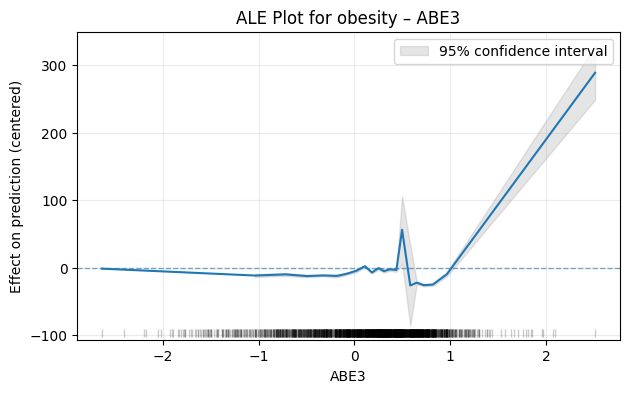

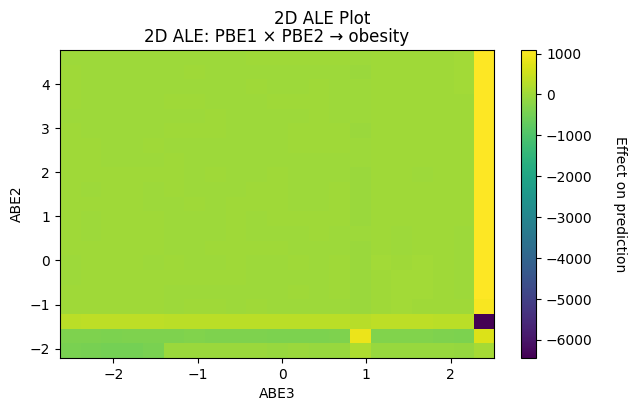

In [9]:
features_for_ale = ['ABE2', 'ABE3']
dependent_vars = ['bphigh', 'chd', 'diabetes', 'highchol', 'obesity']  # adjust if needed
grid = 20

for target in dependent_vars:
    print(f"\n[ALE] {target}")

    # Use only PBE1 & PBE2; drop rows with missing values
    df = gdf[features_for_ale + [target]].dropna(subset=features_for_ale + [target])
    X  = df[features_for_ale]
    y  = df[target]

    # Fit your specified RF (cap max_features to #cols to avoid errors)
    rf = RandomForestRegressor(
        n_estimators=500,
        max_features=min(6, X.shape[1]),
        random_state=42
    )
    rf.fit(X, y)

    # --- 1D ALE: analyze PBE1 (pass FULL X; specify feature=['PBE1']) ---
    fig, ax = plt.subplots(figsize=(7, 4))
    ale(
        X=X, model=rf,
        feature=['ABE2'], grid_size=grid,
        include_CI=True, fig=fig, ax=ax
    )
    ax.axhline(0, linestyle='--', linewidth=1, alpha=0.6)
    ax.set_xlabel('ABE2')
    ax.set_ylabel('Effect on prediction (centered)')
    ax.set_title(f"ALE Plot for {target} – ABE2")
    ax.grid(True, alpha=0.25)
    plt.show()

    # --- 1D ALE: analyze PBE2 (again pass FULL X) ---
    fig, ax = plt.subplots(figsize=(7, 4))
    ale(
        X=X, model=rf,
        feature=['ABE3'], grid_size=grid,
        include_CI=True, fig=fig, ax=ax
    )
    ax.axhline(0, linestyle='--', linewidth=1, alpha=0.6)
    ax.set_xlabel('ABE3')
    ax.set_ylabel('Effect on prediction (centered)')
    ax.set_title(f"ALE Plot for {target} – ABE3")
    ax.grid(True, alpha=0.25)
    plt.show()

    # --- 2D ALE: interaction PBE1 × PBE2 ---
    fig, ax = plt.subplots(figsize=(7, 4))
    ale(
        X=X, model=rf,
        feature=['ABE2', 'ABE3'], grid_size=grid,
        fig=fig, ax=ax
    )
    ax.set_title(f"2D ALE: PBE1 × PBE2 → {target}")
    plt.show()


[ALE] bphigh


PyALE._ALE_generic:INFO: Continuous feature detected.


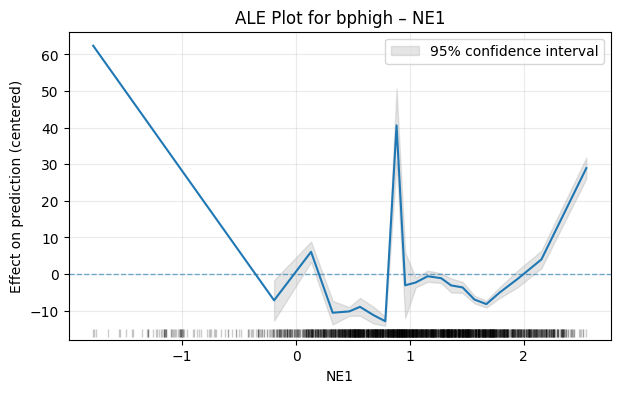

PyALE._ALE_generic:INFO: Continuous feature detected.


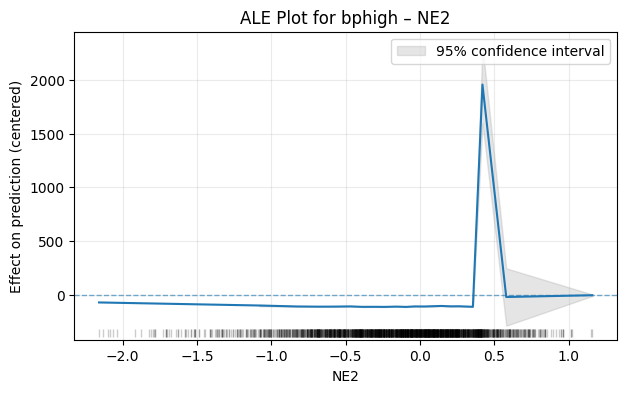

PyALE._ALE_generic:INFO: Continuous feature detected.


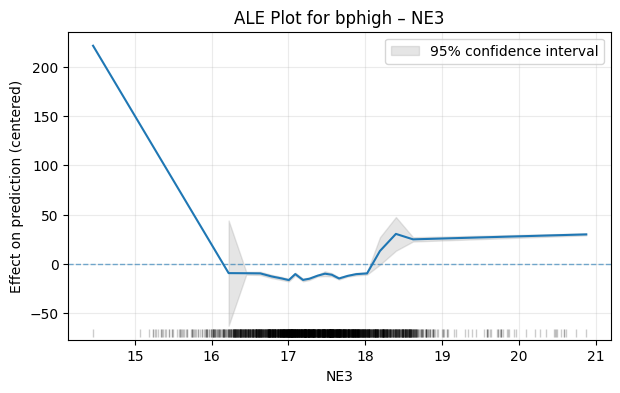


[ALE] chd


PyALE._ALE_generic:INFO: Continuous feature detected.


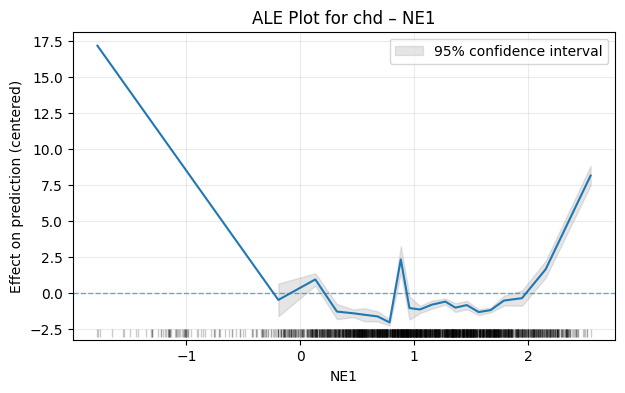

PyALE._ALE_generic:INFO: Continuous feature detected.


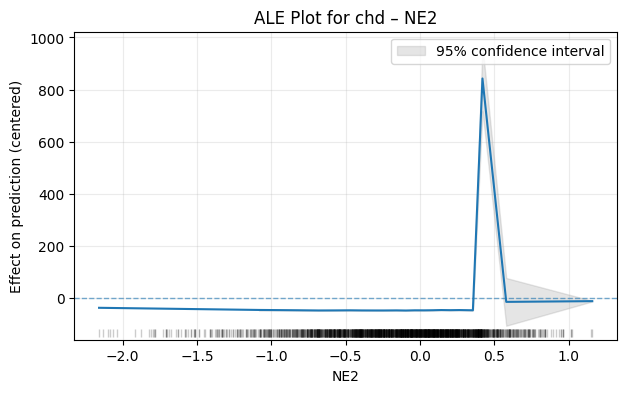

PyALE._ALE_generic:INFO: Continuous feature detected.


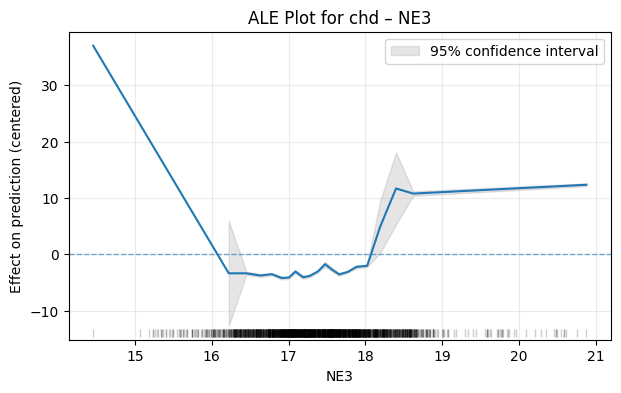


[ALE] diabetes


PyALE._ALE_generic:INFO: Continuous feature detected.


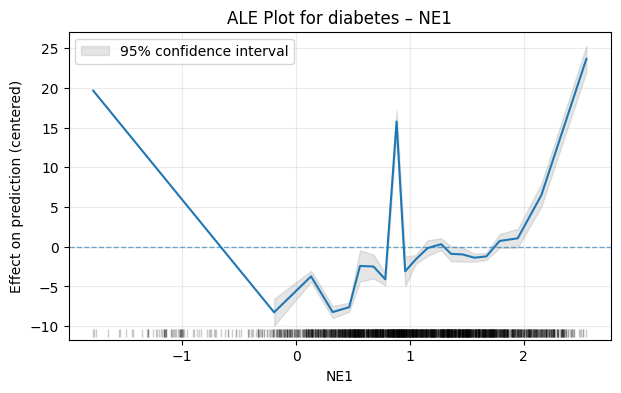

PyALE._ALE_generic:INFO: Continuous feature detected.


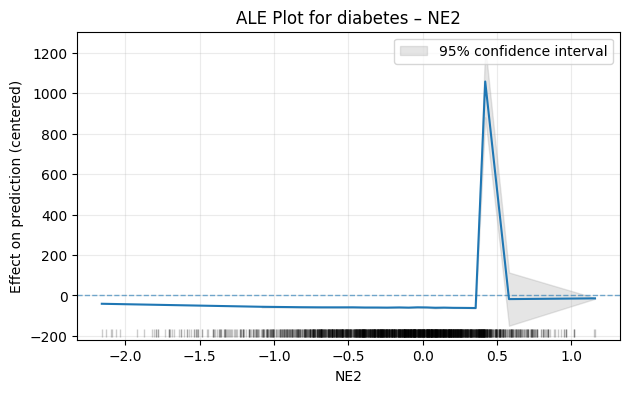

PyALE._ALE_generic:INFO: Continuous feature detected.


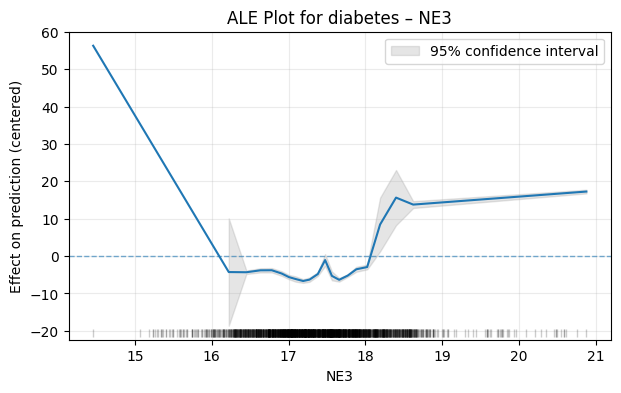


[ALE] highchol


PyALE._ALE_generic:INFO: Continuous feature detected.


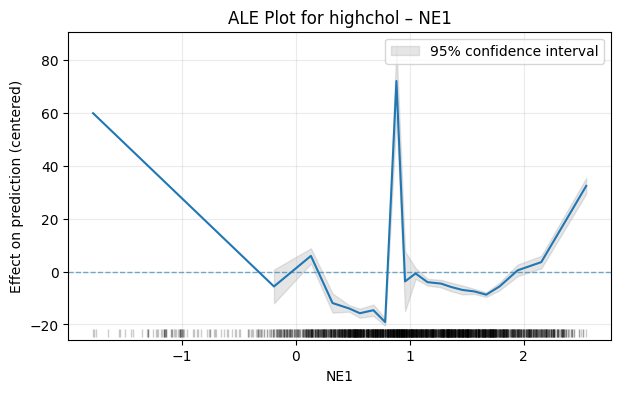

PyALE._ALE_generic:INFO: Continuous feature detected.


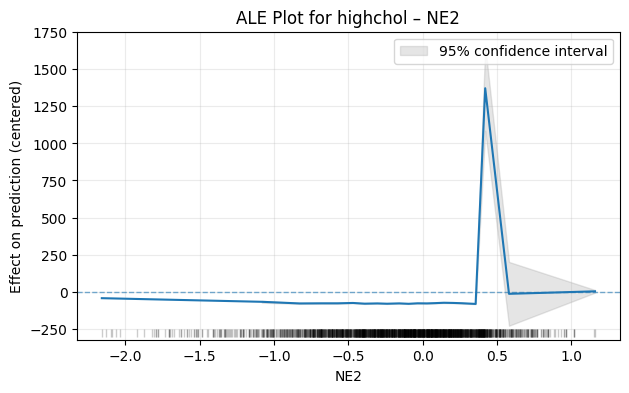

PyALE._ALE_generic:INFO: Continuous feature detected.


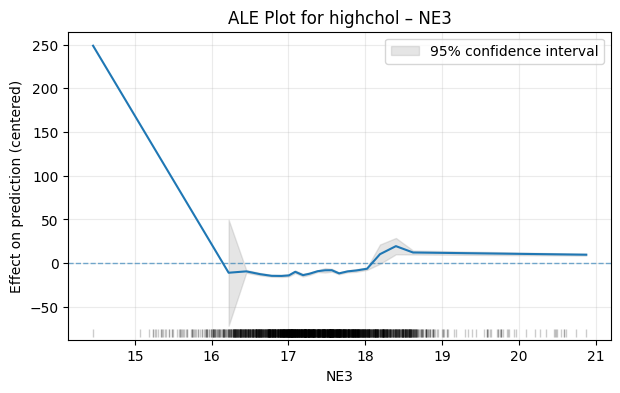


[ALE] obesity


PyALE._ALE_generic:INFO: Continuous feature detected.


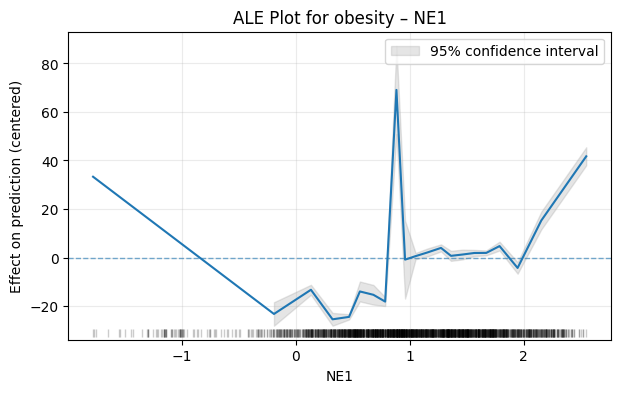

PyALE._ALE_generic:INFO: Continuous feature detected.


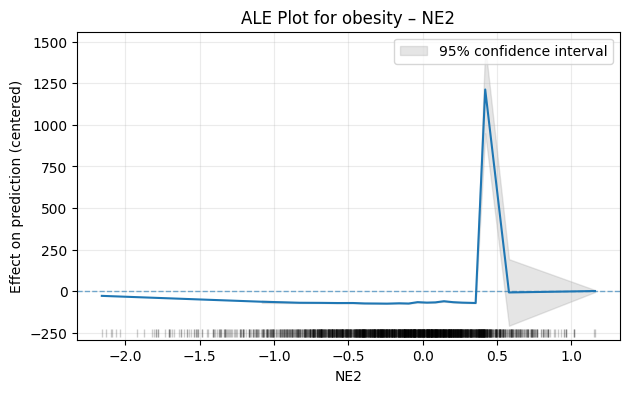

PyALE._ALE_generic:INFO: Continuous feature detected.


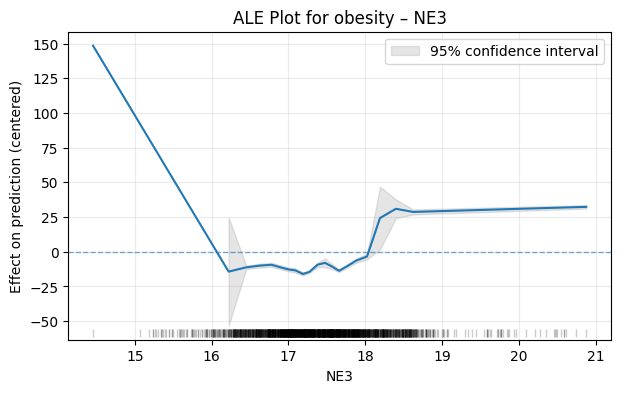

In [8]:
features_for_ale = ['NE1', 'NE2', 'NE3']
dependent_vars = ['bphigh', 'chd', 'diabetes', 'highchol', 'obesity']  # adjust if needed
grid = 20

for target in dependent_vars:
    print(f"\n[ALE] {target}")

    df = gdf[features_for_ale + [target]].dropna(subset=features_for_ale + [target])
    X  = df[features_for_ale]
    y  = df[target]

    # Fit your specified RF (cap max_features to #cols to avoid errors)
    rf = RandomForestRegressor(
        n_estimators=500,
        max_features=min(6, X.shape[1]),
        random_state=42
    )
    rf.fit(X, y)

    for feature in features_for_ale:
        fig, ax = plt.subplots(figsize=(7, 4))
        ale(
            X=X, model=rf,
            feature=[feature], grid_size=grid,
            include_CI=True, fig=fig, ax=ax
        )
        ax.axhline(0, linestyle='--', linewidth=1, alpha=0.6)
        ax.set_xlabel(feature)
        ax.set_ylabel('Effect on prediction (centered)')
        ax.set_title(f"ALE Plot for {target} – {feature}")
        ax.grid(True, alpha=0.25)
        plt.show()
